In [485]:
import numpy as np
import sys,os
import matplotlib.pyplot as plt
from scipy.stats import multivariate_t, norm, multivariate_normal
import sklearn
from sklearn.covariance import GraphicalLasso
import scipy
from sklearn.metrics import zero_one_loss
from sklearn.metrics.pairwise import pairwise_kernels
import time
import tqdm
import networkx as nx
from scipy.optimize import minimize
from scipy.linalg import expm

import matplotlib.pylab as pylab
params = {'legend.fontsize': 25,
         'axes.labelsize': 25,
         'axes.titlesize':25,
         'xtick.labelsize':25,
         'ytick.labelsize':'x-large',
          'axes.titlesize' : 'x-large'}
pylab.rcParams.update(params)
sys.path.insert(0, 'C:/Users/User/Code/DyGraph')

import DyGraph as dg

In [486]:
import numpy as np
from scipy.special import expit as sigmoid
import igraph as ig
import random


def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)


def is_dag(W):
    G = ig.Graph.Weighted_Adjacency(W.tolist())
    return G.is_dag()


def simulate_dag(d, s0, graph_type):
    """Simulate random DAG with some expected number of edges.

    Args:
        d (int): num of nodes
        s0 (int): expected num of edges
        graph_type (str): ER, SF, BP

    Returns:
        B (np.ndarray): [d, d] binary adj matrix of DAG
    """
    def _random_permutation(M):
        # np.random.permutation permutes first axis only
        P = np.random.permutation(np.eye(M.shape[0]))
        return P.T @ M @ P

    def _random_acyclic_orientation(B_und):
        return np.tril(_random_permutation(B_und), k=-1)

    def _graph_to_adjmat(G):
        return np.array(G.get_adjacency().data)

    if graph_type == 'ER':
        # Erdos-Renyi
        G_und = ig.Graph.Erdos_Renyi(n=d, m=s0)
        B_und = _graph_to_adjmat(G_und)
        B = _random_acyclic_orientation(B_und)
    elif graph_type == 'SF':
        # Scale-free, Barabasi-Albert
        G = ig.Graph.Barabasi(n=d, m=int(round(s0 / d)), directed=True)
        B = _graph_to_adjmat(G)
    elif graph_type == 'BP':
        # Bipartite, Sec 4.1 of (Gu, Fu, Zhou, 2018)
        top = int(0.2 * d)
        G = ig.Graph.Random_Bipartite(top, d - top, m=s0, directed=True, neimode=ig.OUT)
        B = _graph_to_adjmat(G)
    else:
        raise ValueError('unknown graph type')
    B_perm = _random_permutation(B)
    assert ig.Graph.Adjacency(B_perm.tolist()).is_dag()
    return B_perm


def simulate_parameter(B, w_ranges=((-2.0, -0.5), (0.5, 2.0))):
    """Simulate SEM parameters for a DAG.

    Args:
        B (np.ndarray): [d, d] binary adj matrix of DAG
        w_ranges (tuple): disjoint weight ranges

    Returns:
        W (np.ndarray): [d, d] weighted adj matrix of DAG
    """
    W = np.zeros(B.shape)
    S = np.random.randint(len(w_ranges), size=B.shape)  # which range
    for i, (low, high) in enumerate(w_ranges):
        U = np.random.uniform(low=low, high=high, size=B.shape)
        W += B * (S == i) * U
    return W


def simulate_linear_sem(W, n, sem_type, noise_scale=None):
    """Simulate samples from linear SEM with specified type of noise.

    For uniform, noise z ~ uniform(-a, a), where a = noise_scale.

    Args:
        W (np.ndarray): [d, d] weighted adj matrix of DAG
        n (int): num of samples, n=inf mimics population risk
        sem_type (str): gauss, exp, gumbel, uniform, logistic, poisson
        noise_scale (np.ndarray): scale parameter of additive noise, default all ones

    Returns:
        X (np.ndarray): [n, d] sample matrix, [d, d] if n=inf
    """
    def _simulate_single_equation(X, w, scale):
        """X: [n, num of parents], w: [num of parents], x: [n]"""
        if sem_type == 'gauss':
            z = np.random.normal(scale=scale, size=n)
            x = X @ w + z
        elif sem_type == 'exp':
            z = np.random.exponential(scale=scale, size=n)
            x = X @ w + z
        elif sem_type == 'gumbel':
            z = np.random.gumbel(scale=scale, size=n)
            x = X @ w + z
        elif sem_type == 'uniform':
            z = np.random.uniform(low=-scale, high=scale, size=n)
            x = X @ w + z
        elif sem_type == 'logistic':
            x = np.random.binomial(1, sigmoid(X @ w)) * 1.0
        elif sem_type == 'poisson':
            x = np.random.poisson(np.exp(X @ w)) * 1.0
        else:
            raise ValueError('unknown sem type')
        return x

    d = W.shape[0]
    if noise_scale is None:
        scale_vec = np.ones(d)
    elif np.isscalar(noise_scale):
        scale_vec = noise_scale * np.ones(d)
    else:
        if len(noise_scale) != d:
            raise ValueError('noise scale must be a scalar or has length d')
        scale_vec = noise_scale
    if not is_dag(W):
        raise ValueError('W must be a DAG')
    if np.isinf(n):  # population risk for linear gauss SEM
        if sem_type == 'gauss':
            # make 1/d X'X = true cov
            X = np.sqrt(d) * np.diag(scale_vec) @ np.linalg.inv(np.eye(d) - W)
            return X
        else:
            raise ValueError('population risk not available')
    # empirical risk
    G = ig.Graph.Weighted_Adjacency(W.tolist())
    ordered_vertices = G.topological_sorting()
    assert len(ordered_vertices) == d
    X = np.zeros([n, d])
    for j in ordered_vertices:
        parents = G.neighbors(j, mode=ig.IN)
        X[:, j] = _simulate_single_equation(X[:, parents], W[parents, j], scale_vec[j])
    return X


def simulate_nonlinear_sem(B, n, sem_type, noise_scale=None):
    """Simulate samples from nonlinear SEM.

    Args:
        B (np.ndarray): [d, d] binary adj matrix of DAG
        n (int): num of samples
        sem_type (str): mlp, mim, gp, gp-add
        noise_scale (np.ndarray): scale parameter of additive noise, default all ones

    Returns:
        X (np.ndarray): [n, d] sample matrix
    """
    def _simulate_single_equation(X, scale):
        """X: [n, num of parents], x: [n]"""
        z = np.random.normal(scale=scale, size=n)
        pa_size = X.shape[1]
        if pa_size == 0:
            return z
        if sem_type == 'mlp':
            hidden = 100
            W1 = np.random.uniform(low=0.5, high=2.0, size=[pa_size, hidden])
            W1[np.random.rand(*W1.shape) < 0.5] *= -1
            W2 = np.random.uniform(low=0.5, high=2.0, size=hidden)
            W2[np.random.rand(hidden) < 0.5] *= -1
            x = sigmoid(X @ W1) @ W2 + z
        elif sem_type == 'mim':
            w1 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
            w1[np.random.rand(pa_size) < 0.5] *= -1
            w2 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
            w2[np.random.rand(pa_size) < 0.5] *= -1
            w3 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
            w3[np.random.rand(pa_size) < 0.5] *= -1
            x = np.tanh(X @ w1) + np.cos(X @ w2) + np.sin(X @ w3) + z
        elif sem_type == 'gp':
            from sklearn.gaussian_process import GaussianProcessRegressor
            gp = GaussianProcessRegressor()
            x = gp.sample_y(X, random_state=None).flatten() + z
        elif sem_type == 'gp-add':
            from sklearn.gaussian_process import GaussianProcessRegressor
            gp = GaussianProcessRegressor()
            x = sum([gp.sample_y(X[:, i, None], random_state=None).flatten()
                     for i in range(X.shape[1])]) + z
        else:
            raise ValueError('unknown sem type')
        return x

    d = B.shape[0]
    scale_vec = noise_scale if noise_scale else np.ones(d)
    X = np.zeros([n, d])
    G = ig.Graph.Adjacency(B.tolist())
    ordered_vertices = G.topological_sorting()
    assert len(ordered_vertices) == d
    for j in ordered_vertices:
        parents = G.neighbors(j, mode=ig.IN)
        X[:, j] = _simulate_single_equation(X[:, parents], scale_vec[j])
    return X



In [487]:
import numpy as np
import scipy.linalg as slin
import scipy.optimize as sopt
from scipy.special import expit as sigmoid


def notears_linear(X, lambda1, loss_type, max_iter=100, h_tol=1e-8, rho_max=1e+16, w_threshold=0.3):
    """Solve min_W L(W; X) + lambda1 ‖W‖_1 s.t. h(W) = 0 using augmented Lagrangian.

    Args:
        X (np.ndarray): [n, d] sample matrix
        lambda1 (float): l1 penalty parameter
        loss_type (str): l2, logistic, poisson
        max_iter (int): max num of dual ascent steps
        h_tol (float): exit if |h(w_est)| <= htol
        rho_max (float): exit if rho >= rho_max
        w_threshold (float): drop edge if |weight| < threshold

    Returns:
        W_est (np.ndarray): [d, d] estimated DAG
    """
    def _loss(W):
        """Evaluate value and gradient of loss."""
        M = X @ W
        if loss_type == 'l2':
            R = X - M
            loss = 0.5 / X.shape[0] * (R ** 2).sum()
            G_loss = - 1.0 / X.shape[0] * X.T @ R
        elif loss_type == 'logistic':
            loss = 1.0 / X.shape[0] * (np.logaddexp(0, M) - X * M).sum()
            G_loss = 1.0 / X.shape[0] * X.T @ (sigmoid(M) - X)
        elif loss_type == 'poisson':
            S = np.exp(M)
            loss = 1.0 / X.shape[0] * (S - X * M).sum()
            G_loss = 1.0 / X.shape[0] * X.T @ (S - X)
        else:
            raise ValueError('unknown loss type')
        return loss, G_loss

    def _h(W):
        """Evaluate value and gradient of acyclicity constraint."""
        E = slin.expm(W * W)  # (Zheng et al. 2018)
        h = np.trace(E) - d
        #     # A different formulation, slightly faster at the cost of numerical stability
        #     M = np.eye(d) + W * W / d  # (Yu et al. 2019)
        #     E = np.linalg.matrix_power(M, d - 1)
        #     h = (E.T * M).sum() - d
        G_h = E.T * W * 2
        return h, G_h

    def _adj(w):
        """Convert doubled variables ([2 d^2] array) back to original variables ([d, d] matrix)."""
        return (w[:d * d] - w[d * d:]).reshape([d, d])

    def _func(w):
        """Evaluate value and gradient of augmented Lagrangian for doubled variables ([2 d^2] array)."""
        W = _adj(w)
        loss, G_loss = _loss(W)
        h, G_h = _h(W)
        obj = loss + 0.5 * rho * h * h + alpha * h + lambda1 * w.sum()
        G_smooth = G_loss + (rho * h + alpha) * G_h
        g_obj = np.concatenate((G_smooth + lambda1, - G_smooth + lambda1), axis=None)
        return obj, g_obj

    n, d = X.shape
    w_est, rho, alpha, h = np.zeros(2 * d * d), 1.0, 0.0, np.inf  # double w_est into (w_pos, w_neg)
    bnds = [(0, 0) if i == j else (0, None) for _ in range(2) for i in range(d) for j in range(d)]
    if loss_type == 'l2':
        X = X - np.mean(X, axis=0, keepdims=True)
    for _ in range(max_iter):
        w_new, h_new = None, None
        while rho < rho_max:
            sol = sopt.minimize(_func, w_est, method='L-BFGS-B', jac=True, bounds=bnds)
            w_new = sol.x
            h_new, _ = _h(_adj(w_new))
            if h_new > 0.25 * h:
                rho *= 10
            else:
                break
        w_est, h = w_new, h_new
        alpha += rho * h
        if h <= h_tol or rho >= rho_max:
            break
    W_est = _adj(w_est)
    W_est[np.abs(W_est) < w_threshold] = 0
    return W_est





In [517]:

def soft_threshold_odd( A, lamda):

    """
    diagonal lasso penalty

    Parameters
    ------------------
    A: np.array,
    
    lamda: float,
        regularization
    """
    opt_m = (A-lamda)*(A>=lamda) + (A+lamda)*(A<=-lamda)
    

    return opt_m



def _h(W):
    """Evaluate value and gradient of acyclicity constraint."""
    E = expm(W * W)  # (Zheng et al. 2018)
    h = np.trace(E) - W.shape[0]
    #     # A different formulation, slightly faster at the cost of numerical stability
    #     M = np.eye(d) + W * W / d  # (Yu et al. 2019)
    #     E = np.linalg.matrix_power(M, d - 1)
    #     h = (E.T * M).sum() - d
    G_h = E.T * W * 2
    return h, G_h

Generate DAG data

In [540]:
obs_per_graph = 100
d = 5
X = np.zeros((obs_per_graph, d))
sigma = 0.1
rnd = np.random.RandomState(42)

n, s0, graph_type, sem_type = 1000,  5, 'ER', 'gauss'
I = np.identity(d)
B_true = simulate_dag(d, s0, graph_type)
A = simulate_parameter(B_true)

W = np.linalg.inv(I-A)
for i in range(obs_per_graph):


    X[i] = np.dot(W, np.random.normal(0,1,5))


I = np.identity(X.shape[1])
np.linalg.cond(W)


23.895758831183038

True

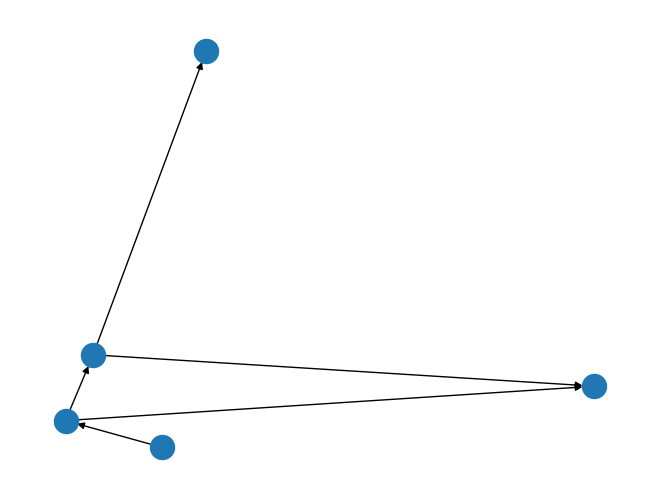

In [541]:
G = nx.from_numpy_array(A,create_using = nx.DiGraph)
nx.draw(G)
nx.is_directed_acyclic_graph(G)

# NO tears

Original Paper code

In [544]:
# set_random_seed(1)

print(A)

A_est = notears_linear(X, lambda1=0.1, loss_type='l2', w_threshold=0)
print(np.round(A_est.T,2))
A_est[np.abs(A_est)<1e-2] = 0
G = nx.from_numpy_array(A_est,create_using = nx.DiGraph)
nx.is_directed_acyclic_graph(G)

[[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.83485807  0.          0.        ]
 [-1.82010469  0.          0.          1.91830353  0.        ]
 [-1.33993634  0.          0.          0.          1.69273396]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.   -0.   -0.   -0.    0.  ]
 [ 0.    0.    0.86  0.    0.  ]
 [-1.62  0.    0.    2.04  0.  ]
 [-1.33  0.    0.    0.    1.49]
 [ 0.    0.    0.    0.    0.  ]]


True

My ADMM implementation of l2 loss

In [549]:

def _loss(W, X):
    """Evaluate value and gradient of loss."""
    M = X @ W

    R = X - M
    loss = 0.5 / X.shape[0] * (R ** 2).sum()
    G_loss = - 1.0 / X.shape[0] * X.T @ R
    return loss, G_loss



# def l2_loss(param,a,u,rho,kappa, X):
#     param = np.reshape(param,(d,d))
#     M = X @ param
#     h,g_h = _h(param)
#     loss, G_loss = _loss(param, X)

#     R = X - M
#     obj = loss +  0.5*kappa*h**2  + 0.5*rho*scipy.linalg.norm(a - param + u, ord = 'fro')**2  
#     G_loss = (G_loss + kappa*h*g_h - rho*(a - param + u)).flatten()
#     return obj, G_loss


def l2_loss(param,a,u,rho,kappa, X):
    param = np.reshape(param,(d,d))
    M = X @ param
    h,g_h = _h(param)

    R = X - M
    loss = 0.5 / X.shape[0] * (R ** 2).sum() +  0.5*kappa*h**2  + 0.5*rho*scipy.linalg.norm(param - a + u, ord = 'fro')**2  
    G_loss = (- 1.0 / X.shape[0] * X.T @ R + kappa*h*g_h + rho*(param - a + u)).flatten()
    return loss, G_loss

u0 = np.array([ np.zeros((d,d)) for  i in range(1)]) # np.array([gen_low_tri() for  i in range(1)])
z0 = np.array([ np.zeros((d,d)) for  i in range(1)]) # np.array([gen_low_tri() for  i in range(1)])
np.fill_diagonal(z0[0], 0)
z1 =  np.array([np.zeros((d,d)) for  i in range(1)]) # np.array([gen_low_tri() for  i in range(1)])
np.fill_diagonal(z1[0], 0)
theta = np.array([np.zeros((d,d)) for i in range(1) ]) # np.random.uniform(-a,a, size=(d,d))
np.fill_diagonal(theta[0], 0)

X_c = X - np.mean(X, axis=0, keepdims=True)
kappa_max = 1e10
lamda = 0.1
alpha = 0
rho = 1
kappa = 1

z0_pre = z0[0]
theta_pre = theta[0]
u0_pre = u0[0]
h = np.inf
for _ in range(10):
    if kappa >= kappa_max:
        break
    w_new, h_new = None, None
    while kappa < kappa_max:

        z0[0] = z0_pre
        theta[0] = theta_pre
        u0[0] = u0_pre
        
        for admm_idx in range(5):
            start = time.time()
            out = minimize(l2_loss, theta[0].flatten(), args = (z0[0], u0[0], rho, kappa, X_c), jac=True, method = 'L-BFGS-B')
            theta[0] = np.reshape(out.x, (d,d))
            np.fill_diagonal(theta[0],0)

            z0[0] = soft_threshold_odd(theta[0] + u0[0]  , lamda/rho) #+ z1[0]-u1[0]
            np.fill_diagonal(z0[0],0)

            u0[0] = u0[0] + theta[0] - z0[0] 

        h_new, _ = _h(theta[0])
        if h_new > 0.25 * h:
            kappa *= 10
            # break
        else:
            break
    h = h_new
    z0_pre = z0[0]
    theta_pre = theta[0]
    u0_pre = u0[0]

print(np.round(theta[0].T,2))
theta[0][np.abs(theta[0])<1e-2] = 0
G = nx.from_numpy_array(theta[0].T,create_using = nx.DiGraph)
print(f" is dag {nx.is_directed_acyclic_graph(G)}")
print("\n")
print(np.round(A,2))

[[ 0.   -0.   -0.   -0.    0.  ]
 [-0.    0.    0.86  0.   -0.  ]
 [-1.62  0.    0.    2.04 -0.  ]
 [-1.33  0.    0.    0.    1.49]
 [ 0.    0.    0.    0.    0.  ]]
 is dag True


[[ 0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.83  0.    0.  ]
 [-1.82  0.    0.    1.92  0.  ]
 [-1.34  0.    0.    0.    1.69]
 [ 0.    0.    0.    0.    0.  ]]


My implementation of Gaussian loss

In [551]:


def gauss_loss(param,a,rho,kappa, S):
    A = np.reshape(param,(d,d))
    h,g_h = _h(A)
    I = np.identity(d)

    IA = I-A
    v,_ = np.linalg.eig(IA)
    gauss_loss = -2*np.sum(np.log(v[v>0])) + 0.5*np.trace(np.dot(IA,IA.T).dot(S))
    g_gauss = 2*np.linalg.inv(IA+0.01*I).T - 2*np.dot(S,IA)
    loss = gauss_loss +  0.5*kappa*h**2  + 0.5*rho*scipy.linalg.norm(A - a, ord = 'fro')**2  
    G_loss = (g_gauss + kappa*h*g_h + rho*(A - a )).flatten()
    return loss, G_loss


z0 = np.array([ np.zeros((d,d)) for  i in range(1)]) # np.array([gen_low_tri() for  i in range(1)])
np.fill_diagonal(z0[0], 0)
theta = np.array([np.zeros((d,d)) for i in range(1) ]) # np.random.uniform(-a,a, size=(d,d))
np.fill_diagonal(theta[0], 0)
u0 = np.array([ np.zeros((d,d)) for  i in range(1)])

X_c = X#  - np.mean(X, axis=0, keepdims=True)
n, d = X_c.shape
S = np.cov(X_c.T)*(n-1)/n
kappa_max = 1e10
lamda = 0.1
alpha = 0
rho = 10
kappa = 1

z0_pre = z0[0]
theta_pre = theta[0]
u0_pre = u0[0]
h = np.inf
for _ in range(10):
    if kappa >= kappa_max:
        break
    w_new, h_new = None, None
    while kappa < kappa_max:

        z0[0] = z0_pre
        theta[0] = theta_pre
        u0[0] = u0_pre
        
        for admm_idx in range(10):
            start = time.time()
            out = minimize(gauss_loss, theta[0].flatten(), args = (z0[0]- u0[0], rho, kappa, S), jac=True, method = 'L-BFGS-B')
            theta[0] = np.reshape(out.x, (d,d))
            np.fill_diagonal(theta[0],0)

            z0[0] = soft_threshold_odd(theta[0] + u0[0]  , lamda/rho) #+ z1[0]-u1[0]
            np.fill_diagonal(z0[0],0)

            u0[0] = u0[0] + theta[0] - z0[0] 

        h_new, _ = _h(theta[0])
        if h_new > 0.25 * h:
            kappa *= 10
        else:
            break
    h = h_new
    z0_pre = z0[0]
    theta_pre = theta[0]
    u0_pre = u0[0]


print(np.round(theta[0].T,2))
theta[0][np.abs(theta[0])<1e-1] = 0
G = nx.from_numpy_array(theta[0].T,create_using = nx.DiGraph)
print(f" is dag {nx.is_directed_acyclic_graph(G)}")
print("\n")
print(np.round(A,2))

[[ 0.   -0.   -0.    0.    0.01]
 [-0.7   0.    0.31  1.25 -0.06]
 [-1.16  0.    0.    2.09  0.11]
 [-0.71  0.    0.    0.    0.92]
 [ 0.05  0.    0.    0.    0.  ]]
 is dag True


[[ 0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.83  0.    0.  ]
 [-1.82  0.    0.    1.92  0.  ]
 [-1.34  0.    0.    0.    1.69]
 [ 0.    0.    0.    0.    0.  ]]


Seems to work, but Gaussian is more noisy. Might be because of log det and inversion. Will have a look. Have to apply a threshold to, make it a DAG.

# Temporal

In [532]:
A1  = np. array([[ 0.        , -1.89159833,  0.        ,  1.09628855,  0.        ],
       [ 0.        ,  0.        , -0.9,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -1,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.44408539,  0.        ,  0.        ]])

A2 = A1.copy()
A2[0,3] = 0

A3 = A2.copy()

A = [A1, A2, A3]
X_dynamic = []
obs_per_graph = 100
for t in range(3):
    x_tmp = np.zeros((obs_per_graph, d))
    I = np.identity(d)
    W_tmp = np.linalg.inv(I-A[t])
    for i in range(obs_per_graph):

        x_tmp[i] = np.dot(W_tmp, np.random.normal(0,1,5))

    X_dynamic.append(x_tmp)

X_dynamic = np.vstack(X_dynamic)


In [534]:
A_est = notears_linear(X_dynamic[:100], lambda1=0.01, loss_type='l2', w_threshold=0)
np.round(A_est.T,2)

array([[ 0.  , -1.97, -0.32,  0.82, -0.04],
       [-0.  ,  0.  , -1.03,  0.02,  0.05],
       [ 0.  , -0.  ,  0.  , -0.  ,  0.  ],
       [ 0.  ,  0.  , -1.06,  0.  , -0.06],
       [-0.  ,  0.  ,  1.51, -0.  ,  0.  ]])

l2 ADMM temporal

In [556]:


def _loss(W, X):
    """Evaluate value and gradient of loss."""
    M = X @ W

    R = X - M
    loss = 0.5 / X.shape[0] * (R ** 2).sum()
    G_loss = - 1.0 / X.shape[0] * X.T @ R
    return loss, G_loss


def l2_loss(param,a,rho,kappa, X):
    param = np.reshape(param,(d,d))
    M = X @ param
    h,g_h = _h(param)

    R = X - M
    loss = 0.5 / X.shape[0] * (R ** 2).sum() +  0.5*kappa*h**2  + 0.5*rho*scipy.linalg.norm(param - a, ord = 'fro')**2  
    G_loss = (- 1.0 / X.shape[0] * X.T @ R + kappa*h*g_h + rho*(param - a)).flatten()
    return loss, G_loss

T = 3
z0 = np.array([ np.zeros((d,d)) for  i in range(T)]) # np.array([gen_low_tri() for  i in range(1)])
z1 =  np.array([np.zeros((d,d)) for  i in range(T)]) # np.array([gen_low_tri() for  i in range(1)])
z2 =  np.array([np.zeros((d,d)) for  i in range(T)]) # np.array([gen_low_tri() for  i in range(1)])

u0 = np.array([ np.zeros((d,d)) for  i in range(T)]) # np.array([gen_low_tri() for  i in range(1)])
u1 =  np.array([np.zeros((d,d)) for  i in range(T)]) # np.array([gen_low_tri() for  i in range(1)])
u2 =  np.array([np.zeros((d,d)) for  i in range(T)]) # np.array([gen_low_tri() for  i in range(1)])

theta = np.array([np.zeros((d,d)) for i in range(T) ]) # np.random.uniform(-a,a, size=(d,d))
np.fill_diagonal(theta[0], 0)

X_c = X_dynamic - np.mean(X_dynamic, axis=0, keepdims=True)
kappa_max = 1e10
lamda = 0.1
alpha = 0.3
rho = 1
kappa = 1

z0_pre = z0
theta_pre = theta
u0_pre = u0
h = np.inf
for _ in range(10):
    if kappa >= kappa_max:
        break
    w_new, h_new = None, None
    while kappa < kappa_max:

        z0 = z0_pre
        theta = theta_pre
        u0 = u0_pre
        u1_pre = u1
        u2_pre = u2
        
        for admm_idx in range(5):
            for t in range(T):
                if t == 0 or t == T:
                    A_tmp = (z0[t] + z1[t] + z2[t] - u0[t] - u1[t] - u2[t])/2.0
                else:
                    A_tmp = (z0[t] + z1[t] + z2[t] - u0[t] - u1[t] - u2[t])/3.0
                
                out = minimize(l2_loss, theta[t].flatten(), args = (A_tmp, rho, kappa, X_c[t*obs_per_graph:(t+1)*obs_per_graph]), jac=True, method = 'L-BFGS-B')
                theta[t] = np.reshape(out.x, (d,d))
                np.fill_diagonal(theta[t],0)

            start = time.time()
            for t in range(T):
                z0[t] = soft_threshold_odd(theta[t] + u0[t], lamda/rho) #+ z1[0]-u1[0]
                np.fill_diagonal(z0[t],0)

            for t in range(1,T):
                A_star = theta[t]-theta[t-1]+u2[t]-u1[t-1]

                E = soft_threshold_odd(A_star, 2*alpha/rho)
                summ = 0.5*(theta[t]+theta[t-1]+u1[t-1]+u2[t])
                z1[t-1] = summ - 0.5*E
                z2[t] = summ + 0.5*E

            u0 = u0 + theta - z0
            u1[:(T-1)] = u1[:(T-1)] + theta[:(T-1)]-z1[:(T-1)]
            u2[1:] = u2[1:] + theta[1:] - z2[1:]

        h_new, _ = _h(theta[0])
        if h_new > 0.25 * h:
            kappa *= 10
        else:
            break
    h = h_new
    z0_pre = z0
    theta_pre = theta
    u0_pre = u0
    u1_pre = u1
    u2_pre = u2
np.set_printoptions(suppress=True)
print(np.round(theta[0].T,2))
theta[0][np.abs(theta[0])<1e-1] = 0
G = nx.from_numpy_array(theta[0].T,create_using = nx.DiGraph)
print(f" is dag {nx.is_directed_acyclic_graph(G)}")
print("\n")
print(np.round(theta[1].T,2))
theta[1][np.abs(theta[1])<1e-1] = 0
G = nx.from_numpy_array(theta[1].T,create_using = nx.DiGraph)
print(f" is dag {nx.is_directed_acyclic_graph(G)}")
print("\n")
print(np.round(theta[2].T,2))
theta[2][np.abs(theta[2])<1e-1] = 0
G = nx.from_numpy_array(theta[2].T,create_using = nx.DiGraph)
print(f" is dag {nx.is_directed_acyclic_graph(G)}")

[[ 0.   -1.87  0.    0.81 -0.09]
 [-0.    0.   -0.73  0.01 -0.08]
 [ 0.   -0.    0.   -0.    0.  ]
 [ 0.    0.01 -0.84  0.   -0.09]
 [-0.   -0.    1.4  -0.    0.  ]]
 is dag True


[[ 0.   -1.87  0.08  0.05 -0.  ]
 [-0.    0.   -0.74  0.02 -0.09]
 [ 0.   -0.    0.   -0.    0.  ]
 [ 0.01  0.01 -0.84  0.   -0.07]
 [ 0.   -0.    1.4  -0.    0.  ]]
 is dag True


[[ 0.   -1.63  0.08  0.    0.04]
 [-0.    0.   -0.54  0.02 -0.09]
 [ 0.   -0.    0.   -0.    0.  ]
 [-0.    0.01 -0.67  0.   -0.07]
 [ 0.01 -0.    1.08 -0.    0.  ]]
 is dag True


In [537]:
A_dynamic[0]

array([[ 0.        , -1.89159833,  0.        ,  1.09628855,  0.        ],
       [ 0.        ,  0.        , -0.9       ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.44408539,  0.        ,  0.        ]])

Gaussian temporal

In [557]:
def gauss_loss(param,a,rho,kappa, S):
    A = np.reshape(param,(d,d))
    h,g_h = _h(A)
    I = np.identity(d)

    IA = I-A
    v,_ = np.linalg.eig(IA)
    gauss_loss = -2*np.sum(np.log(v[v>0])) + 0.5*np.trace(np.dot(IA,IA.T).dot(S))
    g_gauss = np.linalg.inv(IA+0.1*I).T - np.dot(S,IA)
    loss = gauss_loss +  0.5*kappa*h**2  + 0.5*rho*scipy.linalg.norm(A - a, ord = 'fro')**2  
    G_loss = (g_gauss + kappa*h*g_h + rho*(A - a )).flatten()
    return loss, G_loss


T = 3
z0 = np.array([ np.zeros((d,d)) for  i in range(T)]) # np.array([gen_low_tri() for  i in range(1)])
z1 =  np.array([np.zeros((d,d)) for  i in range(T)]) # np.array([gen_low_tri() for  i in range(1)])
z2 =  np.array([np.zeros((d,d)) for  i in range(T)]) # np.array([gen_low_tri() for  i in range(1)])

u0 = np.array([ np.zeros((d,d)) for  i in range(T)]) # np.array([gen_low_tri() for  i in range(1)])
u1 =  np.array([np.zeros((d,d)) for  i in range(T)]) # np.array([gen_low_tri() for  i in range(1)])
u2 =  np.array([np.zeros((d,d)) for  i in range(T)]) # np.array([gen_low_tri() for  i in range(1)])

theta = np.array([np.zeros((d,d)) for i in range(T) ]) # np.random.uniform(-a,a, size=(d,d))
# np.fill_diagonal(theta[0], 0)

X_c = X_dynamic - np.mean(X_dynamic, axis=0, keepdims=True)
kappa_max = 1e10
lamda = 0.1
alpha = 0.8
rho = 1
kappa = 1

z0_pre = z0
z1_pre = z1
z2_pre = z2
theta_pre = theta
u0_pre = u0
h = np.inf
for _ in range(10):
    if kappa >= kappa_max:
        break
    w_new, h_new = None, None
    while kappa < kappa_max:

        z0 = z0_pre
        z1 = z1_pre
        z2 = z2_pre
        theta = theta_pre
        u0 = u0_pre
        u1_pre = u1
        u2_pre = u2
        
        for admm_idx in range(5):
            for t in range(T):
                if t == 0 or t == T:
                    A_tmp = (z0[t] + z1[t] + z2[t] - u0[t] - u1[t] - u2[t])/2.0
                else:
                    A_tmp = (z0[t] + z1[t] + z2[t] - u0[t] - u1[t] - u2[t])/3.0
                
                S = np.cov(X_c[t*obs_per_graph:(t+1)*obs_per_graph].T)*(obs_per_graph-1)/obs_per_graph
                out = minimize(gauss_loss, theta[t].flatten(), args = (A_tmp, rho, kappa, S), jac=True, method = 'L-BFGS-B')
                theta[t] = np.reshape(out.x, (d,d))
                #np.fill_diagonal(theta[t],0)

            start = time.time()
            for t in range(T):
                z0[t] = soft_threshold_odd(theta[t] + u0[t], lamda/rho) #+ z1[0]-u1[0]
                # np.fill_diagonal(z0[t],0)

            for t in range(1,T):
                A_star = theta[t]-theta[t-1]+u2[t]-u1[t-1]

                E = soft_threshold_odd(A_star, 2*alpha/rho)
                summ = 0.5*(theta[t]+theta[t-1]+u1[t-1]+u2[t])
                z1[t-1] = summ - 0.5*E
                z2[t] = summ + 0.5*E

            u0 = u0 + theta - z0
            u1[:(T-1)] = u1[:(T-1)] + theta[:(T-1)]-z1[:(T-1)]
            u2[1:] = u2[1:] + theta[1:] - z2[1:]

        h_new, _ = _h(theta[0])
        if h_new > 0.25 * h:
            kappa *= 10
        else:
            break
    h = h_new
    z0_pre = z0
    z1_pre = z1
    z2_pre = z2
    theta_pre = theta
    u0_pre = u0
    u1_pre = u1
    u2_pre = u2
np.set_printoptions(suppress=True)
print(np.round(theta[0].T,2))
theta[0][np.abs(theta[0])<1e-1] = 0
G = nx.from_numpy_array(theta[0].T,create_using = nx.DiGraph)
print(f" is dag {nx.is_directed_acyclic_graph(G)}")
print("\n")
print(np.round(theta[1].T,2))
theta[1][np.abs(theta[1])<1e-1] = 0
G = nx.from_numpy_array(theta[1].T,create_using = nx.DiGraph)
print(f" is dag {nx.is_directed_acyclic_graph(G)}")
print("\n")
print(np.round(theta[2].T,2))
theta[2][np.abs(theta[2])<1e-1] = 0
G = nx.from_numpy_array(theta[2].T,create_using = nx.DiGraph)
print(f" is dag {nx.is_directed_acyclic_graph(G)}")

[[ 0.   -1.75  0.06  0.66 -0.1 ]
 [-0.   -0.   -0.54  0.03 -0.13]
 [ 0.   -0.    0.   -0.    0.  ]
 [-0.   -0.03 -0.75  0.   -0.15]
 [-0.   -0.    1.25 -0.    0.  ]]
 is dag True


[[ 0.   -1.82  0.07  0.01 -0.05]
 [-0.   -0.   -0.65 -0.   -0.1 ]
 [ 0.   -0.   -0.   -0.    0.  ]
 [ 0.09  0.25 -0.89 -0.    0.  ]
 [-0.   -0.    1.24 -0.08 -0.  ]]
 is dag True


[[ 0.   -1.75  0.05 -0.    0.01]
 [-0.    0.   -0.54  0.01 -0.15]
 [ 0.    0.   -0.   -0.   -0.  ]
 [ 0.04  0.06 -0.79  0.   -0.05]
 [-0.   -0.01  1.16 -0.    0.  ]]
 is dag True
